In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Defining the path for train and test images 

In [58]:
import pathlib


# train_dir = 'ISIC/Train'
# test_dir = 'ISIC/Test'

data_dir_train = pathlib.Path("ISIC/Train")
data_dir_test = pathlib.Path('ISIC/Test')

Get the image counts for Train and Test data

In [59]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180

In [60]:

batch_size = 32
img_height = 180
img_width = 180
     

In [61]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)




Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [63]:
# This code lists the class names in the train dataset
print(train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize one instance of all the nine classes present in the dataset 

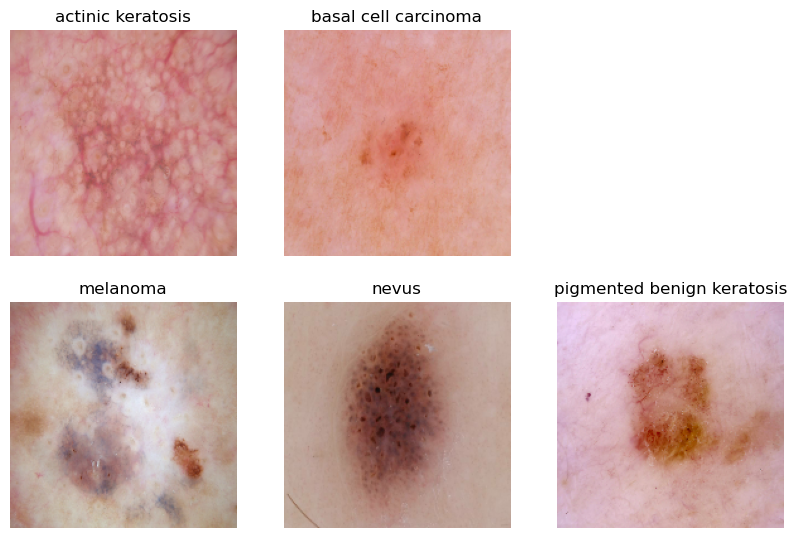

In [64]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for i in range(9):
    for images, labels in train_ds.take(1):
        for j in range(9):
            img = images[j].numpy().astype("uint8")
            label = labels[j]
            if class_names[label] == class_names[i]:
                plt.subplot(3, 3, i+1)
                plt.imshow(img)
                plt.title(class_names[i])
                plt.axis("off")
                break
plt.show()



Data augmentation using Keras library

In [62]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model Building & training : '

Create a CNN model, which can accurately detect 9 classes present in the dataset. 

While building the model, rescale images to normalize pixel values between (0,1).

Choose an appropriate optimiser and loss function for model training

Train the model for ~20 epochs

In [65]:
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    # layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9,activation='softmax')
])



In [66]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])



In [67]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    16,588,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,613,673 (63.38 MB)

 Trainable params: 16,613,673 (63.38 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 267ms/step - accuracy: 0.2475 - loss: 2.8360 - val_accuracy: 0.4452 - val_loss: 1.6564
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - accuracy: 0.4381 - loss: 1.5929 - val_accuracy: 0.3602 - val_loss: 1.7618
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.4111 - loss: 1.6613 - val_accuracy: 0.4989 - val_loss: 1.4416
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.5035 - loss: 1.3925 - val_accuracy: 0.4899 - val_loss: 1.4670
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.5128 - loss: 1.4124 - val_accuracy: 0.4922 - val_loss: 1.5123
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.4944 - loss: 1.3654 - val_accuracy: 0.5257 - val_loss: 1.3873
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.5629 - loss: 1.2502 - val_accuracy: 0.5235 - val_loss: 1.4386
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.5314 - loss: 1.3152 - val_accu

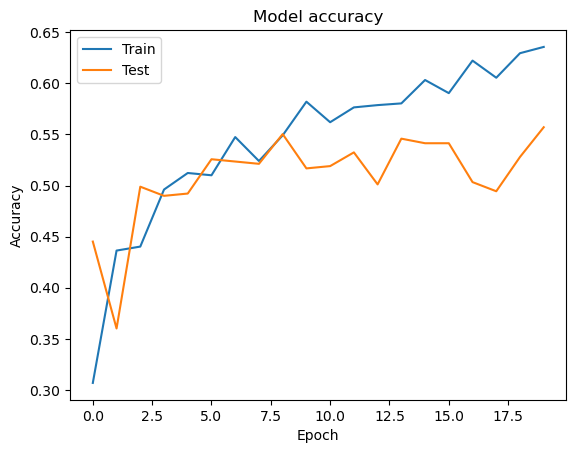

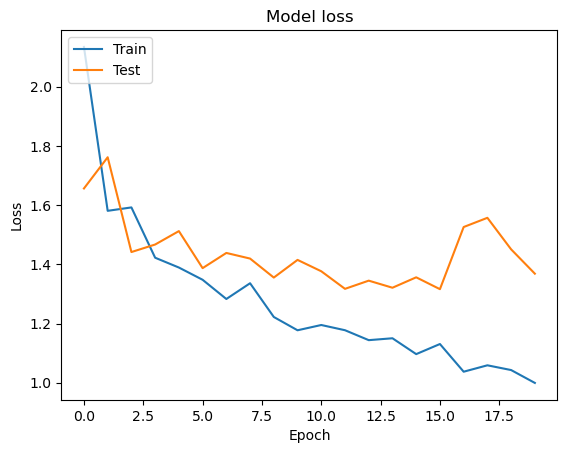

Model is overfitting


In [69]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Check for overfitting or underfitting
if history.history['accuracy'][-1] > history.history['val_accuracy'][-1]:
    print("Model is overfitting")
elif history.history['accuracy'][-1] < history.history['val_accuracy'][-1]:
    print("Model is underfitting")
else:
    print("Model is well-fit")




Findings:

For the first few epochs the model is completely overfitting

As the training loss dereases with epochs the validation loss stabilizes

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around 50% accuracy on the validation set.

The difference in accuracy between training and validation accuracy is noticeable which is a sign of overfitting.


Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

In [71]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

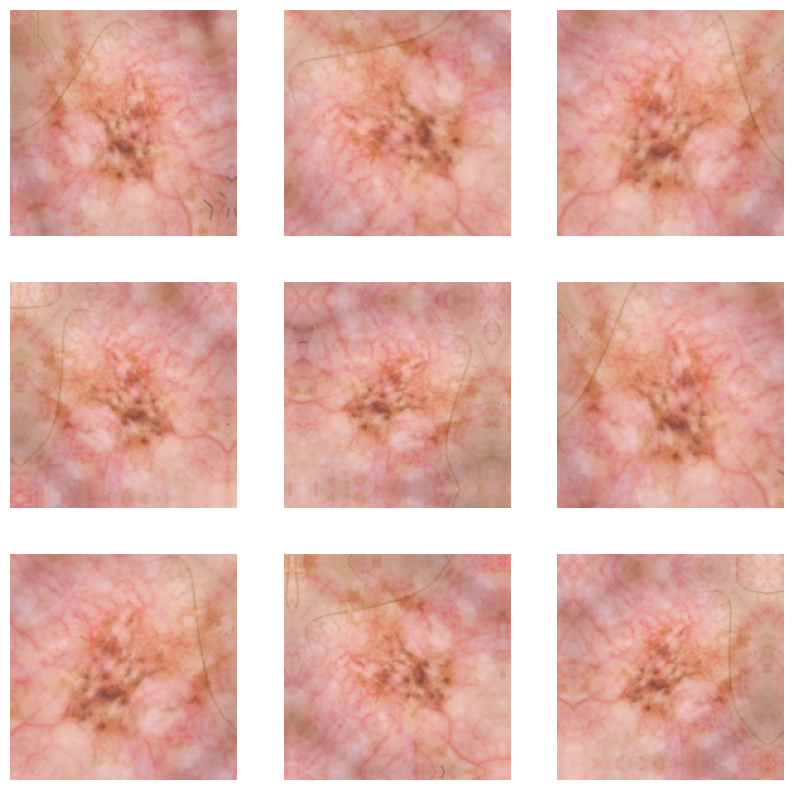

In [73]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Model Building & training on the augmented data :

Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).

Choose an appropriate optimiser and loss function for model training

Train the model for ~20 epochs

In [80]:
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(9,activation='softmax')
])


In [81]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# history = model.fit(datagen.flow(images, labels, batch_size=32), epochs=10, steps_per_epoch=len(images) // 32)


In [82]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_12 (Rescaling)        │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (32, 180, 180, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (32, 90, 90, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (32, 90, 90, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (32, 45, 45, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (32, 45, 45, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (32, 61952)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 256)              │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 9)                │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
# history = model.fit(data_augmentation.flow(images, labels, batch_size=32), epochs=10, steps_per_epoch=len(images) // 32)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 538ms/step - accuracy: 0.2088 - loss: 3.2231 - val_accuracy: 0.3870 - val_loss: 1.7969
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 473ms/step - accuracy: 0.3876 - loss: 1.7329 - val_accuracy: 0.4452 - val_loss: 1.6026
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 450ms/step - accuracy: 0.4189 - loss: 1.6407 - val_accuracy: 0.4430 - val_loss: 1.5542
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - accuracy: 0.4512 - loss: 1.5483 - val_accuracy: 0.5280 - val_loss: 1.4415
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 480ms/step - accuracy: 0.4985 - loss: 1.4187 - val_accuracy: 0.4989 - val_loss: 1.4328
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 521ms/step - accuracy: 0.5291 - loss: 1.3707 - val_accuracy: 0.5034 - val_loss: 1.4046
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 463ms/step - accuracy: 0.5286 - loss: 1.3273 - val_accuracy: 0.4922 - val_loss: 1.4132
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 422ms/step - accuracy: 0.5276 - loss: 1.3249 - val_accu

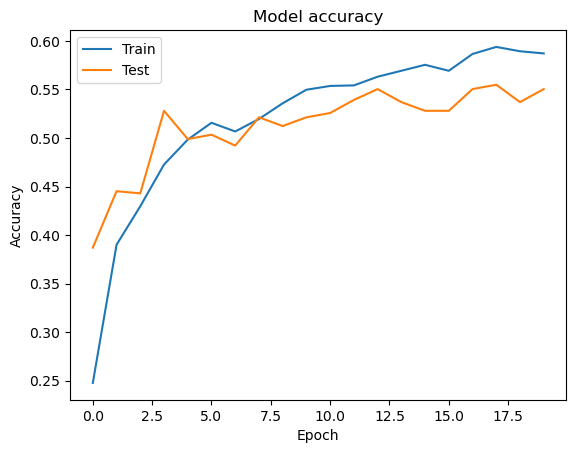

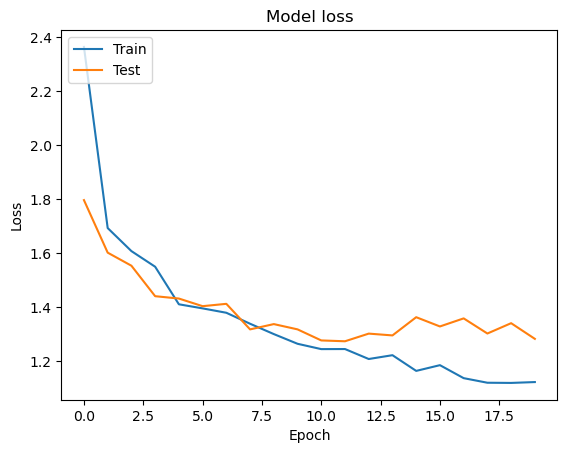

Model is overfitting


In [84]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Check for overfitting or underfitting
if history.history['accuracy'][-1] > history.history['val_accuracy'][-1]:
    print("Model is overfitting")
elif history.history['accuracy'][-1] < history.history['val_accuracy'][-1]:
    print("Model is underfitting")
else:
    print("Model is well-fit")




Findings:

As the training accuracy increases linearly over time, where as the validation accuracy increases and stabilizes at 55% accuracy in training process.

As the training loss decreases with epochs the validation loss decreases and stalls.

The difference in accuracy between training and validation accuracy is still noticeable which is a sign of overfitting.

Class distribution: Examine the current class distribution in the training dataset 

In [85]:
# Get the class distribution of the labels
import numpy as np

# Assuming 'labels' is the variable containing the labels
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the class distribution
for i, (label, count) in enumerate(zip(unique_labels, counts)):
    print(f"Class {label}: {count} ({count/len(labels)*100:.2f}%)")



Class 0: 1 (3.12%)
Class 1: 4 (12.50%)
Class 3: 9 (28.12%)
Class 4: 7 (21.88%)
Class 5: 5 (15.62%)
Class 6: 3 (9.38%)
Class 7: 3 (9.38%)


In [87]:
class_names = train_ds.class_names
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


Handling class imbalances: Rectify class imbalances present in the training dataset with Augmentor library.

In [88]:
!pip install Augmentor

In [92]:
from Augmentor import Pipeline
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x35B24CA50>: 100%|██████████| 500/500 [00:02<00:00, 180.73 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3348DEB90>: 100%|██████████| 500/500 [00:03<00:00, 153.52 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x35B1C65D0>: 100%|██████████| 500/500 [00:02<00:00, 238.55 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x36ADFEF10>: 100%|██████████| 500/500 [00:12<00:00, 41.25 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x3344EBF90>: 100%|██████████| 500/500 [00:11<00:00, 42.70 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x35A912A10>: 100%|██████████| 500/500 [00:03<00:00, 159.40 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x35B259D90>: 100%|██████████| 500/500 [00:07<00:00, 69.55 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3684CF510>: 100%|██████████| 500/500 [00:02<00:00, 240.03 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x334BE0FD0>: 100%|██████████| 500/500 [00:02<00:00, 229.78 Samples/s]                  


In [94]:
import os
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]


In [96]:
dict_new = dict(zip(path_list, lesion_list_new))
import pandas as pd
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [97]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [98]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Model Building & training on the rectified class imbalance data :

Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).

Choose an appropriate optimiser and loss function for model training

Train the model for ~30 epochs

In [105]:
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # layers.Conv2D(256, 3, padding='same', activation='relu'),
    # layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(9,activation='softmax')
])

In [106]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [107]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_15 (Rescaling)        │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (32, 180, 180, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (32, 90, 90, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (32, 90, 90, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (32, 45, 45, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 45, 45, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (32, 259200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (32, 256)              │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (32, 9)                │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 165s 965ms/step - accuracy: 0.1701 - loss: 3.4476 - val_accuracy: 0.3831 - val_loss: 1.6393
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 151s 894ms/step - accuracy: 0.3713 - loss: 1.6365 - val_accuracy: 0.3898 - val_loss: 1.5738
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.3796 - loss: 1.5910 - val_accuracy: 0.4588 - val_loss: 1.4197
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 168s 988ms/step - accuracy: 0.4187 - loss: 1.4795 - val_accuracy: 0.4573 - val_loss: 1.3886
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 158s 934ms/step - accuracy: 0.4623 - loss: 1.3983 - val_accuracy: 0.4840 - val_loss: 1.3336
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.4641 - loss: 1.4133 - val_accuracy: 0.4826 - val_loss: 1.3198
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 169s 994ms/step - accuracy: 0.4685 - loss: 1.3502 - val_accuracy: 0.4981 - val_loss: 1.2718
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 156s 922ms/step - accuracy: 0.4926 - loss:

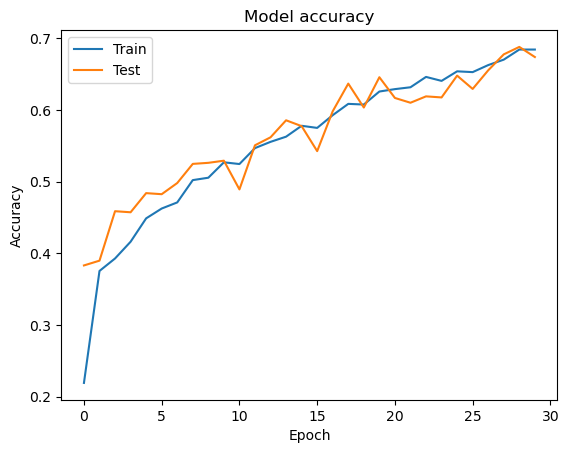

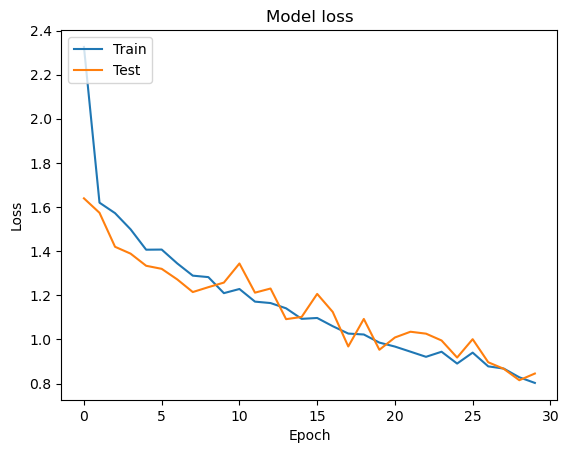

Model is overfitting


In [109]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Check for overfitting or underfitting
if history.history['accuracy'][-1] > history.history['val_accuracy'][-1]:
    print("Model is overfitting")
elif history.history['accuracy'][-1] < history.history['val_accuracy'][-1]:
    print("Model is underfitting")
else:
    print("Model is well-fit")




Conclusion

As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.

As the training loss decreases with epochs the validation loss also decreases.

The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 68% accuracy on the validation set.

The difference in accuracy between training and validation accuracy is very less

Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 68%.